# AutoTrader (Q-Learning Trader)

This project aims to create a Q-Learning that learns how to trade cryptocurrencies by analysising historical data and finding the patterns of which indicates whether the agent should `BUY`, `SELL` or `NADA` when choosing its actions.

### Data Source

The data source for this experiment will be from the US-based cryptocurrency exchange [Poloniex](http://poloniex.com/). Where there are dozens of digital assets readily available for trading.

In [88]:
# Pretty display for notebooks
%matplotlib inline


# Increase size of inline plots
from pylab import rcParams
rcParams['figure.figsize'] = 16, 8

# Load poloniex API Wrapper
from poloniex import Poloniex
from datetime import datetime, date, timedelta
import time
import pandas as pd
import numpy as np
#import seaborn as sns
#np.random.seed(sum(map(ord, "aesthetics")))
#from market_env import DataSource

from IPython.display import display # Allows the use of display() for DataFrames

# Previously set random_state, so that we can have reproducibility of results
random_state = 42

# Build data into data frame
def build_dataframe(data, unit = 's'):
  df = pd.DataFrame.from_dict(data)
  df['date'] = pd.to_datetime(df['date'], unit=unit)
  df.set_index('date', inplace=True)
  df = df.convert_objects(convert_numeric=True)
  return df

def to_timestamp(dt):
  return (dt - datetime(1970, 1, 1)).total_seconds()


pol = Poloniex()
pair = 'BTC_ETH'

start_date = to_timestamp(datetime(2015, 12, 31))
#end_date = to_timestamp(datetime(2016, 12, 31))
end_date = time.time()

# Timestamp periods
SECOND = 1
MINUTE = 60 * SECOND
HOUR = MINUTE * 60
DAY = 24 * HOUR
WEEK = 7 * DAY

def scale(df):
  mean_values = df.mean(axis=0)
  std_values = df.std(axis=0)
  return (df - np.array(mean_values))/ np.array(std_values)
  

## Get data from Coin Market Cap
def coin_market_cap_data():  
  import requests
  bitcoin_data = "http://coinmarketcap.northpole.ro/history.json?coin=bitcoin&year=2016"
  r = requests.get(bitcoin_data)
  coin_mkt_cap = build_dataframe(r.json()['history'], None)
  coin_mkt_cap['price'] = [float(p['usd']) for p in coin_mkt_cap['price']]
  coin_mkt_cap['marketCap'] = [float(p['usd']) for p in coin_mkt_cap['marketCap']]
  coin_mkt_cap['volume24'] = [float(p['usd']) for p in coin_mkt_cap['volume24']]
  return coin_mkt_cap


period = 300 # 5 minutes
data = pol.returnChartData(pair, DAY, start_date, end_date)
data = build_dataframe(data)
data['Return'] = data['close'].pct_change()

pctrank = lambda x: pd.Series(x).rank(pct=True).iloc[-1]
data['ClosePctl'] = data['close'].expanding(100).apply(pctrank)
data['VolumePctl'] = data['volume'].expanding(100).apply(pctrank)

#data['close'].plot()
scale(data).plot()

TypeError: arg must be a list, tuple, 1-d array, or Series

In [6]:
import gym
import pandas as pd
import numpy as np
import math
from poloniex import Poloniex

def sharpe_ratio(returns, freq=365) :
  """Given a set of returns, calculates naive (rfr=0) sharpe """
  return (np.sqrt(freq) * np.mean(returns))/np.std(returns)

def prices_to_returns(prices):
  px = pd.DataFrame(prices)
  nl = px.shift().fillna(0)
  R = ((px - nl)/nl).fillna(0).replace([np.inf, -np.inf], np.nan).dropna()
  R = np.append( R[0].values, 0)
  return R

In [7]:
class PPoloniexDataSource(object):
  '''
  DataSource US-based exchange Poloniex: poloniex.com
  '''
  FEATURES = ['close', 'volume', 'daily_return', 'rolling_mean', 'close_sma_ratio']
  
  def __init__(self, client = Poloniex, api_key = '', secret_key = ''):
    self.api_key = api_key
    self.secret_key = secret_key  
    self.client = client(self.api_key, self.secret_key)

  def _featurize(self, df, scale = True):
    df['daily_return'] = df['close'].pct_change()
    df.dropna(axis=0, inplace=True)
    rolling_mean = pd.stats.moments.rolling_mean(df['close'], 30)
    df.dropna(axis=0, inplace=True)
    df['rolling_mean'] = rolling_mean
    df['close_sma_ratio'] = df['close'] / rolling_mean
    daily_return = df['daily_return']
    if scale:
      mean_values = df.mean(axis=0)
      std_values = df.std(axis=0)
      df = (df - np.array(mean_values))/ np.array(std_values)
    #df['daily_return'] = daily_return
    
    return df[self.FEATURES]
  
  def get_historical_data(self, pair, period, start_date, end_date):
    df = pd.DataFrame.from_dict(
      self.client.returnChartData(pair, period, start_date, end_date)
    )
    df['date'] = pd.to_datetime(df['date'], unit='s')
    df.set_index('date', inplace=True)
    df = df.convert_objects(convert_numeric=True)
    return self._featurize(df)

In [8]:
class DataSource(object):
    '''
    Class responsible for querying data from Poloniex API, prepares it for the trading environment
    and then also acts as as data source for each step on the environment
    '''
    MinPercentileDays = 100 
    def __init__(self, pair, period, start_date, end_date, days = 365, src = PPoloniexDataSource()):
        self.pair = pair
        self.days = days
        self.data = src.get_historical_data(pair, period, start_date, end_date)
          
    def reset(self):
        self.idx = np.random.randint( low = 0, high=len(self.data.index)-self.days )
        self.step = 0

    def _step(self):
        '''
        Step function is responsible for geting the data for the current step and return it,
        it also returns whether we are done with the data as well
        '''
        obs = self.data.iloc[self.idx].as_matrix()
        self.idx += 1
        self.step += 1
        done = self.step >= self.days
        return obs, done

In [9]:
class Simulator(object) :
  """ Implements core trading simulator for single-instrument univ """

  def __init__(self, steps, trading_cost_bps = 1e-3, time_cost_bps = 1e-4):
    # invariant for object life
    self.trading_cost_bps = trading_cost_bps
    self.time_cost_bps    = time_cost_bps
    self.steps            = steps
    # change every step
    self.step             = 0
    self.actions          = np.zeros(self.steps)
    self.navs             = np.ones(self.steps)
    self.mkt_nav          = np.ones(self.steps)
    self.strat_retrns     = np.ones(self.steps)
    self.posns            = np.zeros(self.steps)
    self.costs            = np.zeros(self.steps)
    self.trades           = np.zeros(self.steps)
    self.mkt_retrns       = np.zeros(self.steps)
    
  def reset(self):
    self.step = 0
    self.actions.fill(0)
    self.portfolio_returns.fill(1)
    self.market_returns.fill(1)
    self.strat_retrns.fill(0)
    self.posns.fill(0)
    self.costs.fill(0)
    self.trades.fill(0)
    self.mkt_retrns.fill(0)
    
  def _step(self, action, retrn ):
    """ Given an action and return for prior period, calculates costs, navs,
        etc and returns the reward and a  summary of the day's activity. """


    bod_posn = 0.0 if self.step == 0 else self.posns[self.step-1]
    bod_nav  = 1.0 if self.step == 0 else self.navs[self.step-1]
    mkt_nav  = 1.0 if self.step == 0 else self.mkt_nav[self.step-1]

    self.mkt_retrns[self.step] = retrn
    self.actions[self.step] = action
    
    self.posns[self.step] = action - 1     
    self.trades[self.step] = self.posns[self.step] - bod_posn
    
    trade_costs_pct = abs(self.trades[self.step]) * self.trading_cost_bps 
    self.costs[self.step] = trade_costs_pct +  self.time_cost_bps
    reward = ( (bod_posn * retrn) - self.costs[self.step] )
    self.strat_retrns[self.step] = reward

    if self.step != 0 :
      self.navs[self.step] =  bod_nav * (1 + self.strat_retrns[self.step-1])
      self.mkt_nav[self.step] =  mkt_nav * (1 + self.mkt_retrns[self.step-1])
    
    info = { 'reward': reward, 'nav':self.navs[self.step], 'costs':self.costs[self.step] }

    self.step += 1      
    return reward, info

  def to_df(self):
    """returns internal state in new dataframe """
    cols = ['action', 'bod_nav', 'mkt_nav','mkt_return','sim_return',
            'position','costs', 'trade' ]
    rets = _prices2returns(self.navs)
    #pdb.set_trace()
    df = pd.DataFrame( {'action':     self.actions, # today's action (from agent)
                          'bod_nav':    self.navs,    # BOD Net Asset Value (NAV)
                          'mkt_nav':  self.mkt_nav, 
                          'mkt_return': self.mkt_retrns,
                          'sim_return': self.strat_retrns,
                          'position':   self.posns,   # EOD position
                          'costs':  self.costs,   # eod costs
                          'trade':  self.trades },# eod trade
                         columns=cols)
    return df

In [10]:
class Simulator(object):
  
  def __init__(self, steps, trading_cost = 0, time_cost = 1e-4):
    self.steps = steps
    self.trading_cost = trading_cost
    self.time_cost = time_cost
    
    # Variables to be updated every step
    self.step = 0
    self.actions = np.zeros(self.steps)
    self.positions = np.zeros(self.steps)
    self.net_asset_values = np.ones(self.steps)
    self.cumulative_returns = np.zeros(self.steps)
    self.sharpe_ratios = np.zeros(self.steps)
    
  def _step(self):
    
    '''
    This function is responsible for:
    
    1. Consult our current position on the coin
    2. Consult our return on investment on this coin
    3. Get the daily info about the coin
      a. daily_return * (1 - cost) if holding_position else: daily_return 
      b. bolinger_bands
    '''
    bod_posn = 0.0 if self.step == 0 else self.positions[self.step-1]
    bod_nav  = 1.0 if self.step == 0 else self.navs[self.step-1]
    mkt_nav  = 1.0 if self.step == 0 else self.mkt_nav[self.step-1]
    
class MarketEnv(gym.Env):
    '''
    This GYM implements an environment in which an agent can simulate cryptocurrency trading
    '''
    def __init__(self):
        pass

    def reset(self):
        pass

    def _step(self):
        pass

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:34: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:15: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=30,center=False).mean()


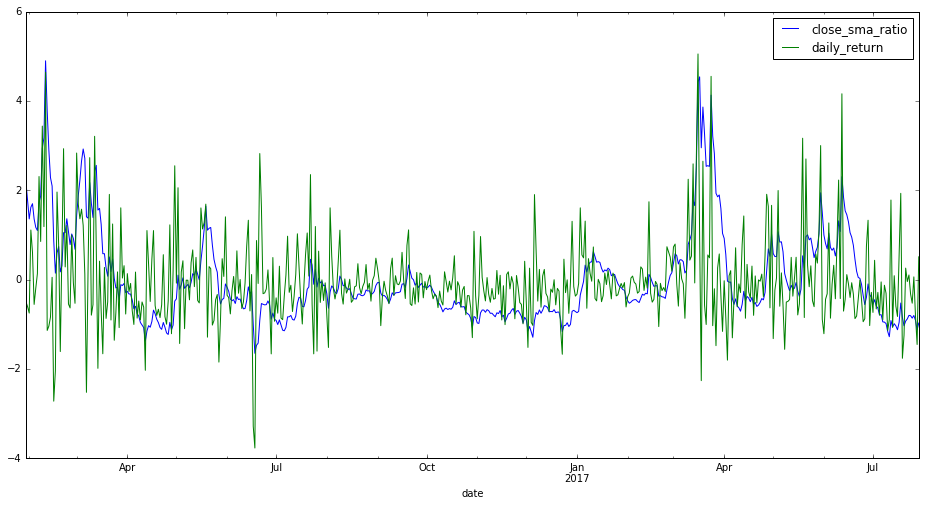

In [11]:

# # get the data from `returnChartData`
src = DataSource(pair, DAY, start_date, end_date)
# display(src.data)


# #src.get_data()['close'].plot()

# #src.get_data()['daily_return'].plot()
src.data.dropna()[['close_sma_ratio', 'daily_return']].plot()
# # src.data['volume_pctl'].plot()

# src.data
# # src.data['close_pctl'].plot()
# pd.DataFrame(
#       np.zeros(src.data.shape),
#       columns=src.data.columns,
#     index=[]
# )

In [81]:





  
start_date = to_timestamp(datetime(2015, 12, 31))
#end_date = to_timestamp(datetime(2016, 12, 31))
end_date = time.time()

# Timestamp periods
SECOND = 1
MINUTE = 60 * SECOND
HOUR = MINUTE * 60
DAY = 24 * HOUR
WEEK = 7 * DAY

days = 365
period_data = {
  'pair': pair,
  'period': DAY,
  'start_date': end_date - days * DAY,
  'end_date': end_date,
  'days': days
}

simulator = TradingSimulator(1.0, PoloniexDataSource(period_data), period_data)


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:35: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


In [82]:
for i in range(len(simulator.trades.index)):
  simulator._step('BUY')

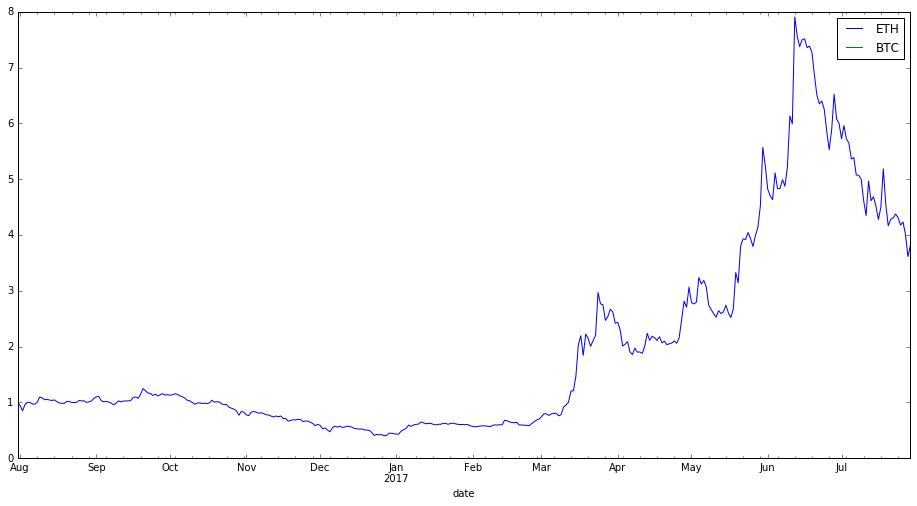

In [86]:
s = simulator
s.values.plot()

In [ ]:


class MarketEnvironment(object):
  VALID_ACTIONS = ['SELL', 'BUY']
  def __init__(self, trial_data, simulator, src, testing = False):
    self.trial_data = trial_data
    self.src = src
    self.simulator = simulator
    self.testing = testing
    self.valid_actions = VALID_ACTIONS
    
  def reset(self):
    self.src.reset()
    self.simulator.reset()

  def step(self, action):
    assert(action in self.valid_actions)
    obs, done = self.src.step()
    reward, info = self.simulator.step(action)
    return reward, obs, info, done
    
    

In [ ]:
sim.prices
#sim.trades

sim.prices.iloc[0]
np.random.randint( low = 0, high=len(sim.prices.index)-365)


In [ ]:

src.data.plot()


In [ ]:
def bbands(price, length=30, numsd=2):
    """ returns average, upper band, and lower band"""
    ave = pd.stats.moments.rolling_mean(price,length)
    sd = pd.stats.moments.rolling_std(price,length)
    upband = ave + (sd*numsd)
    dnband = ave - (sd*numsd)
    return np.round(ave,3), np.round(upband,3), np.round(dnband,3)

df = src.data[['close']]
df['sma'], df['upper'], df['lower'] = bbands(df[['close']])
df.plot()

### Visualize data

There are a few important public datapoints that are important for us in this context:

- We need to know the state of the price at that moment, given a pair. This can be accomplished by calling the `returnTicker` function passing in the trading pair (`BTC_ETH`) as an example.
- Also, it is important to have a feel for what is the state of current orders in the market, what does the current order book for this pair look like? What is the volume being traded?
- Thirdly, its important to have a feel for the price history of that given pair and how its been evolving. What is the daily return? What is the sharpe-ratio? Simple moving average?

### Environment

In order to be able to create a trading bot, we need to be able to simulate a trading environment, where the bot can visualize the current state of the market and take actions depending on it. For this to be done we need:

- An oracle (datasource) responsible for gathering data from the Exchanges client library;
- A Trading simulator that can run the trials of each step the agent needs when choosing an action, this simulator should
- A market environment where the reinforcement learning agent can act upon and measure its performance;
- A reward scheme, where the agent can get rewarded depending on its actions;
- Plot the price history over the trading period.
- Sharpe ratio (Always assume you have 365 trading days in an year. And risk free rate = 0) of the total portfolio
- Cumulative return of the total portfolio
- Standard deviation of daily returns of the total portfolio
- Average daily return of the total portfolio
- Ending value of the portfolio

#### Oracle

An oracle is a class responsible for gathering data from the market, it should:

- Get data fromt the market;
- Transform this data into desirable values. For example, daily return, bolinger value, simple moving average.
- Serve the new data everytime a step is updated;
- Reset the data frame accordingly when the step is over and the `reset()` method is called;

#### Simulator

A trading simulator responsible for simulating the act of trading on the exchange. It should:

- Keep track of the value currently invested in the coin;
- Keep track of the costs incurred with trading in the exchange;
- Compute the reward for user and return the information of this user gathered from the exchange and current state of the market.
- Compute the change in state executed on your own portfolio.
    - What happens when a `buy` order comes in?
        - We should reduce the amount of cash currently available on the account and increase the amount.
    - What happens when a `sell` order comes in?
       - Increase the amount of cash we have and reduce the amount of coins.

#### Exchange

This class is responsible for gathering information about the exchange and the cost incurred with each trade. Also, it should be responsible for keeping track of which positions we currently hold with the exchange. 

- `__init__(trader_id)`
- Build the cost table for the exchange. [See here](https://poloniex.com/fees/)
- `current_cost()` for the user
- `open_trades()`: get open trades method
- `get_balance()`: query this trader's balance

#### Portfolio 

This class is responsible for keeping track of the current trader's own portfolio. It should have:

- `get_portfolio_trades()`
- `buy()` - What happens when a `buy` order comes in? - We should deduce the amount of cash currently available on the account and increase the amount 
- `sell()` - What happens when a `sell` order comes in?

#### Define state space

In order to have a reinforcement learning agent, it is necessary to define the agents state space.

- Do we currently hold any coins or not (of whatever cryptocurrency we are currently trading), this is binary true or false (0 or 1).
- Bolinger value, how is the current state of prices going compared with the simple moving average. This value needs to be discretized, in order to be able to use it as a state. See OpenAI Gym's `Discretize` class. 
- Coin's daily return is also a good value as part of the state. This also needs to be discretized.
- Ration between the close price and the rolling mean (simple moving average)

When what we are trading is bitcoin:
- Number of transactions happening on the blockchain that date; See https://api.blockchain.info/charts/n-transactions?format=json&timespan=all
- Number of unique addresses generated. See: https://blockchain.info/charts/n-unique-addresses
- Number of unspent transaction output. Which basically means the number of unspent bitcoins being generated everyday cumulatively. See: https://blockchain.info/charts/utxo-count
- Estimated transaction value. See: https://blockchain.info/charts/estimated-transaction-volume-usd


#### Actions

- BUY (1)
- SELL (-1)
- NADA (0)

#### Agent

Agent timeline:
1. Aiming to simplify the task at hand, we shall create an agent that chooses the available actions randomly. `RandomAgent`
2. Create a Q-learning agent that trains on 2016 data and tests on 2017. `QAgent`
3. Improve Q-learning agent by introducing the concept of halucination, allowing the agent to halucinate on every single day many possible scenarios for the asset on that day. `QAgent`
